The essence of the Black-Scholes approach to derivatives pricing is that the uncertainty in the final pay-off can be removed by trading in the underlying. 
In this project, we will perform hedging for vanilla call option.

# Required Classes and Functions

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from random import random
from random import randinta

In [0]:
class PayOff:
    def __init__(self, TheOptionsType_, Strike_):
        '''
        Inputs:
        =========
        TheOptionsType_: string (European call, European put, Binary call, Binary put)
        Strike_: float strike price
        '''
        
        self.__TheOptionsType = TheOptionsType_
        self.__Strike = Strike_
        
    def __call__(self,spot):
        # Overloading the ( ) operator
        '''
        inputs:
        =========
        spot: numpy array of spot prices
        
        
        returns:
        =========
        payoff value for each option 
        '''
        
        if self.__TheOptionsType == 'European call':
            return np.maximum(spot - self.__Strike,0)
        elif self.__TheOptionsType == 'European put':
            return np.maximum(self.__Strike - spot,0)
        elif self.__TheOptionsType == 'Binary call':
            return np.piecewise(spot, [spot < self.__Strike, spot >= self.__Strike], [0, 1])
        elif self.__TheOptionsType == 'Binary put':
            return np.piecewise(spot, [spot <= self.__Strike, spot > self.__Strike], [1, 0])
        else:
            raise Exception('Unknown option type found.')

In [8]:
class Option:
    def __init__(self, S, K, r, d, sigma, T):
        '''
        Parameters:
        ===========
        S: stock price 
        K: strike price
        r: risk-free interest rate
        d: dividend 
        sigma: volatility (implied)
        T: time to maturity
        
        
        Returns: 
        ===========
        Forward price, vanilla European call and put option' prices, cash-or-nothing call and put options' prices,
        zero coupon bond and forward contract.
        '''
        
        self.S = S
        self.K = K
        self.r = r
        self.d = d
        self.sigma = sigma
        self.T = T
        
        self.d1 = (np.log(self.S/self.K) + (self.r - self.d + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def forward_price(self):
        '''
        output forward price
        '''        
        return self.S * np.exp(self.r * self.T)
    
    def european_call(self):
        '''
        output vanilla European call option's price using Black-Scholes formula 
        '''        
        return self.S * np.exp(-self.d * self.T) * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T)*norm.cdf(self.d2)
    
    def european_put(self):
        '''
        output vanilla European put option's price using Black-Scholes formula 
        '''        
        return self.K * np.exp(-self.r * self.T)*norm.cdf(-self.d2) - self.S * np.exp(-self.d * self.T)*norm.cdf(-self.d1)
    
    def binary_call(self, face_value):
        '''
        output cash-or-nothing call option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(self.d2)

    def binary_put(self, face_value):
        '''
        ouput cash-or-nothing put option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    
    def zero_coupon_bond(self, face_value):
        '''
        output zero coupon bond's price based on the face value
        '''
        return face_value * np.exp(-self.r * self.T)
    
    def forward_contract(self):
        '''
        output forward contract's value
        '''
        return self.S * np.exp(-self.d * self.T) - self.K * np.exp(-self.r * self.T)
    
    def print_all_values(self, face_value):
        '''
        print prices of all options and zero coupon bond
        '''
        print('Forward price: {}'.format(self.forward_price()))
        print('European call: {}'.format(self.european_call()))
        print('European put: {}'.format(self.european_put()))
        print('Binary call: {}'.format(self.binary_call(face_value = 1)))
        print('Binary put: {}'.format(self.binary_put(face_value = 1)))
        print('Forward contract: {}'.format(self.forward_contract()))

In [9]:
class Greeks(Option):
    '''
    This class contains greeks of the European call option
    '''
    def delta(self):
        return norm.cdf(self.d1)
    
    def gamma(self):
        return norm.pdf(self.d1) / (self.S * self.sigma * np.sqrt(self.T))
    
    def vega(self):
        return self.S * np.sqrt(self.T) * norm.pdf(self.d1)
    
    def rho(self):
        return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def theta(self):
        return - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2) - \
    (self.S * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T))
    
    def print_all(self):
        print('Delta: {}'.format(self.delta()))
        print('Gamma: {}'.format(self.gamma()))
        print('Vega: {}'.format(self.vega()))
        print('Rho: {}'.format(self.rho()))
        print('Theta: {}'.format(self.theta()))

In [34]:
def GBM_formula(S0, K, mu, d, sigma, T, num_paths = 1, seed = None):
    '''
    inputs:
    ===========
    
    S0: initial stock price
    K: strike price
    mu: drift
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_paths: number of paths (integer)
    seed: Control normal distribution generation
    
    returns
    ===========
    
    numpy array containing stock price(s) at time T
    '''
    
    return S0 * np.exp((mu - d - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.RandomState(seed).standard_normal(num_paths))

# The perfect Black-Scholes world

Implement an engine which evolves a stock under a geometric Brownian motion with drift $μ$ and volatility $\sigma$  in $N$ steps using the solution for the stochastic differential equation. 
Write a hedging simulator that accounts for the profits and losses of a hedging strategy against an option payoff, if the interest rate is $r$. 
Implement the Black-Scholes hedging strategy for a call option: hold a Delta amount of stock across each time step. 

Note here we could do the three things quite separately. 
For the reader au fait
with object-oriented programming, one class could handle generation of stock
paths, a second could define hedging strategies and the third could take a path
generation object and a hedging strategy object and actually carry out the simulation.
The best way to approach this would be to use abstract base classes for the
path generation and the hedging strategy from which the specific classes could then
be inherited. If the simulator then takes in objects from the abstract base classes,
new strategies and generators can easily be plugged in later.

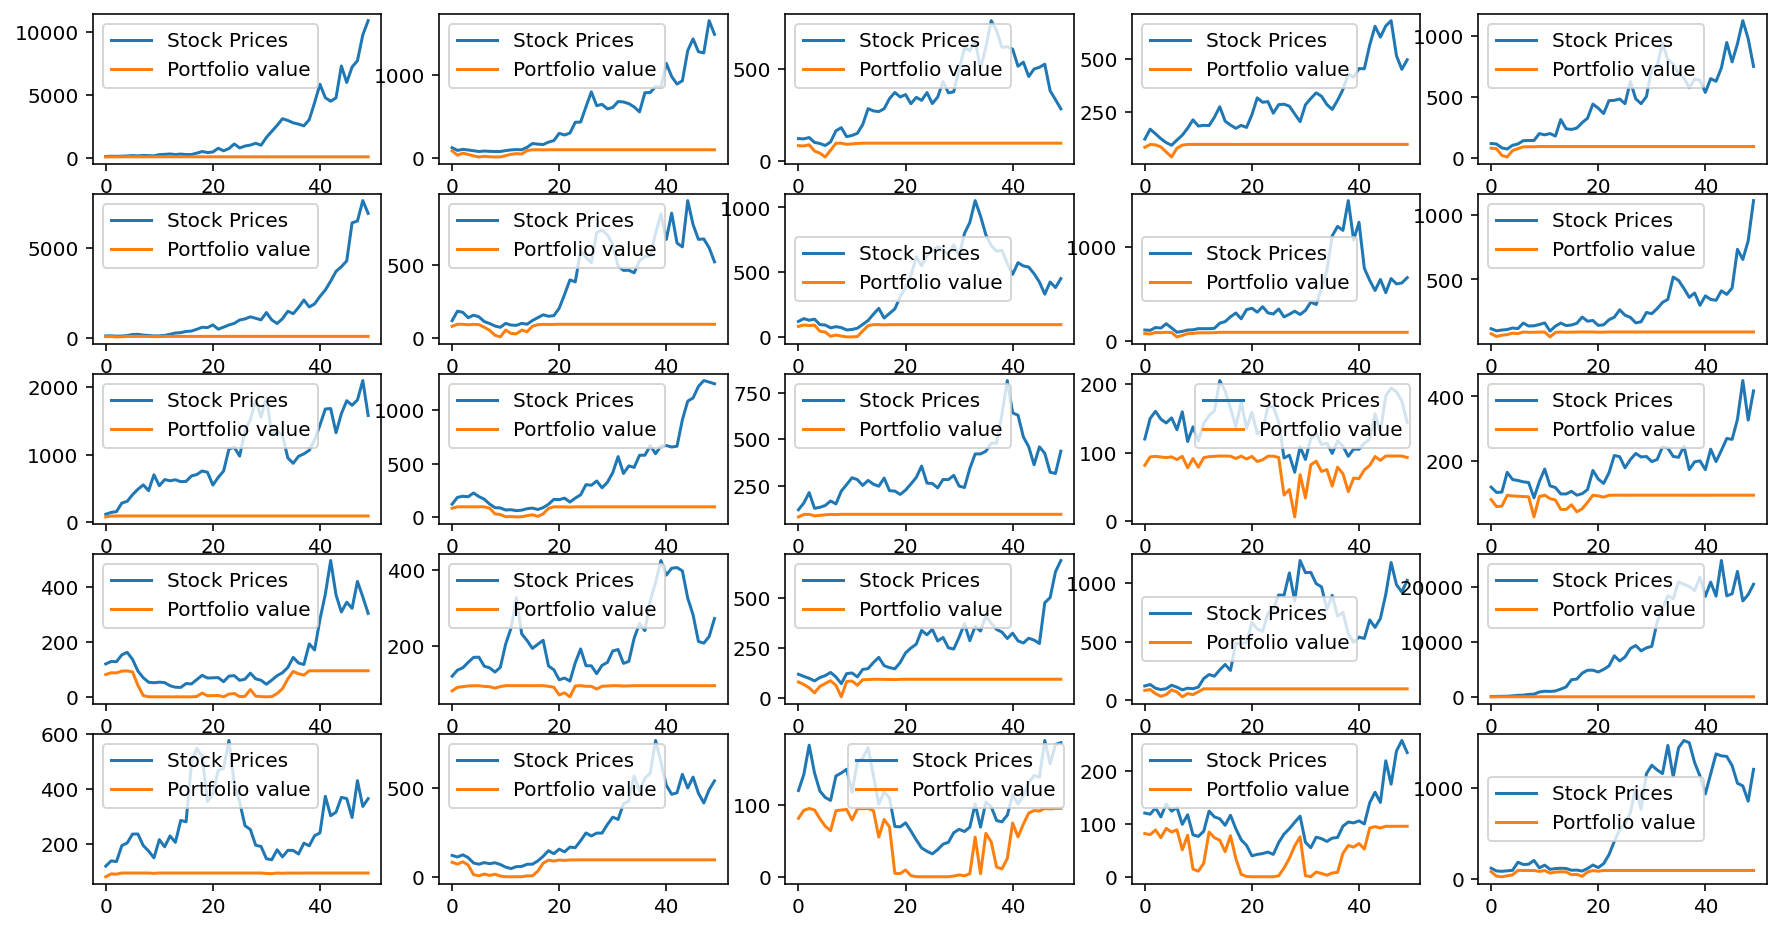

In [59]:
# evolve stock prices under GBM SDE solution in N steps

S0 = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1

N = 50

stock_prices = [0] * N
stock_prices[0] = S0


num_rows, num_cols = 5, 5
num_graphs = num_rows * num_cols

_, ax = plt.subplots(num_rows, num_cols, figsize = (15,8))

for j in range(num_graphs):

    for i in range(1, N):
        stock_prices[i] = GBM_formula(stock_prices[i-1], K, r, d, sigma, T)

    ax[j // num_cols, j % num_cols].plot(stock_prices, label = 'Stock Prices')

    # hedging strategy
    # hedging simulator

    # A delta-neutral portfolio (from option's seller point of view) consists of longing delta shares of stocks and shorting a call option.

    len_of_stock_prices = len(stock_prices)

    portfolio = [0] * len_of_stock_prices

    for i in range(len_of_stock_prices):
        portfolio[i] = Greeks(stock_prices[i], K, r, d, sigma, T).delta() * stock_prices[i] - Option(stock_prices[i], K, r, d, sigma, T).european_call()

    ax[j // num_cols, j % num_cols].plot(portfolio, label = 'Portfolio value')
    ax[j // num_cols, j % num_cols].legend()

# Assessing step-size dependence

Use the hedging simulator to compute the variance of the Delta hedging strategy for various input parameters. 
Plot the variance against the time-step size.
How is the variance affected by changing $\mu$ and $\sigma$?

# The stop-loss strategy

Implement the stop-loss hedging strategy: across a time step hold one unit of stock if spot is greater than or equal to the call option strike and none otherwise. 
How does the variance change with step size? 
How are the mean and variance of the final portfolio affected by changing $\mu$ and $\sigma$?

# Gamma hedging

Extend the hedging simulator to allow hedging with options. 
Implement the Gamma hedging of a far-out-of-the-money option with spot and another option. 
How does the variance change with time-step size?

# Time-dependent volatility

We now try hedging our option when volatility is time-dependent but deterministic.
We therefore have
$$\frac{dS}{S} = \mu dt + \sigma(t) dW_t.$$
To simulate perfectly across a time-step, we take the root-mean-square volatility for that step and put
$$S_{t+\Delta t} = S_t e^{(\mu - \frac{1}{2}\overline{\sigma}^2)\Delta t + \overline{\sigma} \sqrt{\Delta t}  N(0,1) }$$
with $\overline{\sigma}$ the root-mean-square value of $\sigma(t)$ across $[t,t+\Delta t]$, and $N(0, 1)$ a normal draw.

Implement the following hedging methods:

(i) Delta hedge using the current value of $\sigma(t)$ in the formula for the Black-Scholes Delta;

(ii) Delta hedge using the root-mean-square value of $\sigma(t)$ across $[0,T]$ at all times;

(iii) Delta hedge using the root-mean-square value of $\sigma(t)$ across $[s,T]$ at time $s$.

For each method, plot the graph of the variance of final portfolio value against time-step size. 
Extrapolate to get the variance for instantaneous hedging. 
Which one works perfectly, and why is it the only one that does?